# Project Task (Deep Learning) - Group 1

The point of the project is to learn more about the deep hedging approach and variants.

In principle the hedge $H_t = H_t(X_t)$ is learned as a function from its input variable(s) $X_t$ separately for every time point $t$. Its output is one number per traded asset and it shows the number of risky assets to be held. In the most simple set up we used the price of a single traded asset as input and the number to be held as output.

## Group 1 (Transaction costs):

This modification points at the valuation of a strategy $(V_0,H)$. Recall that the terminal wealth of a trading strategy $H$ with initial wealth $V_0$ is given by:
$$V_T = V_0 + \sum_t H_t\Delta S_t.$$
That is, the terminal wealth is the initial wealth plus the traiding gains. If there are additional costs these must be factored in and this will be reflected by modifying the terminal wealth by the accumulated cost $C_T$:
$$V_T = V_0 + \sum_t H_t\Delta S_t - C_t$$
We will model $C_{t+1}:= C_t + a|H_{t+1} - H_t|$ for some given and known number $a>0$. This means that changes in the portfolio (buying or selling) produce some ammount of additional costs.

For simplicity, we will use the *Black-Scholes* model $dS_t = \mu S_tdt + \sigma S_tdW_t$ as a price model for the risky asset, we want to hedge a European call with payoff function $f(x) = \max\{0,x-K\}$ at maturity $T>0$.

I suggest to use the parameter specifications:
$$S_0 = 100, K = 100, T=2, \sigma = 0.2, \mu = 0.08, a\in [0,1]$$
and we use a discretisation to $N=20$ time steps. 

### Create a python script that simulates paths for this model (create $P$ and $Q$ samples).

In [1]:
import numpy as np
import pandas as pd
import statistics
import tensorflow as tf
from keras.layers import Input, Dense, Subtract, Multiply, Lambda, Add
from keras.models import Model
from keras import initializers
import keras.backend as K
import matplotlib.pyplot as plt
import scipy.stats as scipy

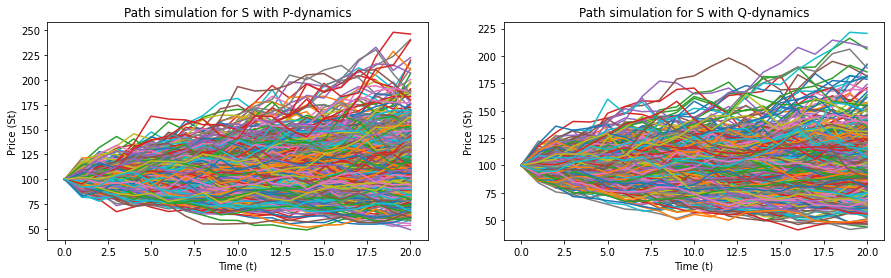

In [2]:
# Trajectories of the Black scholes model
N = 20 # time disrectization
S0 = 100 # initial value of the asset
strike = 100 # strike for the call option
T = 2 # maturity
sigma = 0.2 # volatility in Black Scholes
mu = 0.08 ## P-dynamics
#mu = 0 ## Q-dynamics
R = 500 # number of Trajectories

# Normalising initial value of S0 to 1 (1 unit of money = price of S0)
strike = strike/S0
S0 = 1

def path(S0, mu, sigma, N, T, R):
    dt = T/N
    S = np.zeros((N+1, R), np.float64) + S0
    for j in range(N):
        Z = np.random.normal(0, 1, R)
        increment = np.exp((mu - 0.5*sigma**2)*dt + sigma* np.sqrt(dt)*Z)
        S[j+1,:] = S[j,:]*increment
    return S

# Example of simulations
S_P = path(S0, mu, sigma, N, T, R)
S_Q = path(S0, 0, sigma, N, T, R)

plt.rcParams['figure.figsize'] = [15, 4]
plt.subplot(1, 2, 1)
plt.plot(S_P*100, '-')
plt.title("Path simulation for S with P-dynamics")
plt.xlabel('Time (t)')
plt.ylabel('Price (St)')

plt.subplot(1, 2, 2)
plt.plot(S_Q*100, '-')
plt.title("Path simulation for S with Q-dynamics")
plt.xlabel('Time (t)')
plt.ylabel('Price (St)')
plt.show()

### Create a deep hedging setup with $V_0 = V_0(S_0)$ and $H_t = H_t(S_t)$ incorporating the effect of $a$.

In [3]:
# Definition of neural networks function for computing heding strategies
def Deephedge(activator, a=0):
    m = 1 # dimension of price
    d = 2 # number of layers in strategy
    n = 64 # nodes in the first but last layers

    # Architecture of the network --- expecting a price path
    # Reading initial price of the risky asset. 'price' stands for current price.
    price = Input(shape=(m,))
    # Recording the initial price to the input struture 'inputs'
    inputs = [price]
    # Recording the initial strategy and costs equal to zero
    strategy_prev = 0
    costs = 0

    # The starting wealth
    wealth = Dense(1, activation='linear', trainable=True)(price)

    ## Creating position size and new wealth from current wealth and new asset price
    for j in range(N):
        pricenew = Input(shape=(m,))   # Reading new price
        inputs = inputs + [pricenew]   # Writing new price to the inputs record
        priceshift = Subtract()([pricenew, price])  # Price shift
        ## Creating architecture for the traiding strategy
        for i in range(d):
            ## Choose a layer type
            if i < d-1:
                nodes = n
                layer = Dense(nodes, activation=activator,trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
            else:
                nodes = m
                layer = Dense(nodes, activation='linear', trainable=True,
                              kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(i)+str(j))
            # First layer depends on current price (not newprice)
            if i == 0:
                strategy = layer(price)
            else:
                strategy = layer(strategy)
            
        ## Calculating the accumulated cost
        strategyshift = abs(strategy - strategy_prev) # = |H_t - H_{t-1}|
        costs = costs - a*strategyshift # = C_{t-1} - a*|H_t - H_{t-1}|
        strategy_prev = strategy
        ## Calculating trading gains
        gains = Multiply()([strategy,priceshift])
        ## Calculating new wealth
        wealth = Add()([wealth,gains,costs])  ## current wealth + gains - costs = newwealth
        ## Setting the next price to be the current price for the next iteration
        price = pricenew
    ## Producing the terminal payoff
    payoff = Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
    outputs = Subtract()([payoff,wealth]) # payoff minus terminal wealth

    ## Defining the model: inputs -> outputs
    model_hedge = Model(inputs=inputs, outputs=outputs)

    return model_hedge
    

### Train your model to a test set of sample paths (which activation function works best? relu, tanh?)

#### i) Tangens hyperbolicus

First, let us try our deep hedging algorithm with the hiperbolic activation function (tanh).

In [4]:
# NN train and test parameters
a = 0.01 # costs factor
activator = "tanh"
Ktrain = 20000 # Size of training data
Ktest = 1000 # Size of test data
epochs = 15

trainpaths = path(S0, 0, sigma, N, T, Ktrain) # P-dynamics
    
## Shaping to input architecture
xtrain = []
for i in range(N+1):
    xtrain = xtrain + [trainpaths[i,:]]

# ytrain is filled with zeros
ytrain = np.zeros((Ktrain,1))

model_hedge = Deephedge(activator, a)
model_hedge.summary()


2022-05-01 13:33:49.196201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 00 (Dense)                     (None, 64)           128         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 10 (Dense)                     (None, 1)            65          ['00[0][0]']                     
                                                                                              

 )                                                                'tf.math.multiply_1[0][0]']     
                                                                                                  
 subtract_2 (Subtract)          (None, 1)            0           ['input_4[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 1)           0           ['tf.math.abs_2[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None, 1)            0           ['tf.math.subtract_6[0][0]']     
                                                                                                  
 tf.math.s

 subtract_5 (Subtract)          (None, 1)            0           ['input_7[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 1)           0           ['tf.math.abs_5[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.abs_6 (TFOpLambda)     (None, 1)            0           ['tf.math.subtract_12[0][0]']    
                                                                                                  
 tf.math.subtract_14 (TFOpLambd  (None, 1)           0           ['17[0][0]',                     
 a)                                                               '16[0][0]']                     
          

                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 1)           0           ['tf.math.abs_8[0][0]']          
 )                                                                                                
                                                                                                  
 tf.math.abs_9 (TFOpLambda)     (None, 1)            0           ['tf.math.subtract_18[0][0]']    
                                                                                                  
 tf.math.subtract_20 (TFOpLambd  (None, 1)           0           ['110[0][0]',                    
 a)                                                               '19[0][0]']                     
                                                                                                  
 111 (Dense)                    (None, 1)            65          ['011[0][0]']                    
          

 a)                                                                                               
                                                                                                  
 tf.math.abs_12 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_24[0][0]']    
                                                                                                  
 tf.math.subtract_26 (TFOpLambd  (None, 1)           0           ['113[0][0]',                    
 a)                                                               '112[0][0]']                    
                                                                                                  
 114 (Dense)                    (None, 1)            65          ['014[0][0]']                    
                                                                                                  
 015 (Dense)                    (None, 64)           128         ['input_16[0][0]']               
          

 tf.math.abs_15 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_30[0][0]']    
                                                                                                  
 tf.math.subtract_32 (TFOpLambd  (None, 1)           0           ['116[0][0]',                    
 a)                                                               '115[0][0]']                    
                                                                                                  
 117 (Dense)                    (None, 1)            65          ['017[0][0]']                    
                                                                                                  
 018 (Dense)                    (None, 64)           128         ['input_19[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
          

                                                                  'multiply_16[0][0]',            
                                                                  'tf.math.subtract_33[0][0]']    
                                                                                                  
 multiply_17 (Multiply)         (None, 1)            0           ['117[0][0]',                    
                                                                  'subtract_17[0][0]']            
                                                                                                  
 tf.math.subtract_35 (TFOpLambd  (None, 1)           0           ['tf.math.subtract_33[0][0]',    
 a)                                                               'tf.math.multiply_17[0][0]']    
                                                                                                  
 subtract_18 (Subtract)         (None, 1)            0           ['input_20[0][0]',               
          

In [5]:
model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/15
200/200 [==============================] - 2s 3ms/step - loss: 21.4775
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 0.1943
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0809
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0535
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0399
Epoch 6/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0311
Epoch 7/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0249
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0204
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0170
Epoch 10/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0143
Epoch 11/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0123
Epoch 12/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0106
Epoch 13/15
200/200 [===

### Model Evaluation

Performance of discretised BS-delta-hedge inside BS-model. There is only discretisation error here.


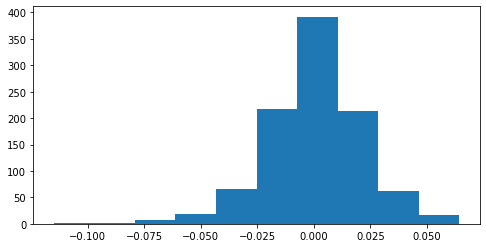

The standar error of the hedge is: 0.021351711283860448
The mean error of the hedge is: 0.00018923806176757458


In [6]:
# Calculating the Delta-hedge in the BS-model
# Blackscholes price formula
def BS(S0, strike, T, sigma):
    d1 = (np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma)
    d2 = d1 - sigma*np.sqrt(T)
    return S0*scipy.norm.cdf(d1) - strike*scipy.norm.cdf(d2)

testpaths = path(S0, 0, sigma, N, T, Ktest) # Q-dynamics
priceBS = BS(S0, strike, T, sigma)
hedge = np.zeros(Ktest)
price = testpaths
for k in range(N):
    d1 = (np.log(price[k,:]/strike) + 0.5*(T - k*T/N)*sigma**2)/(np.sqrt(T - k*T/N)*sigma)
    hedge[:] = hedge[:] + scipy.norm.cdf(d1)*(price[k+1,:] - price[k,:])
hedge[:] = hedge[:] - 0.5*(np.abs(price[N,:] - strike) + (price[N,:] - strike)) + priceBS
print("Performance of discretised BS-delta-hedge inside BS-model. There is only discretisation error here.")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(hedge)
plt.show()
print("The standar error of the hedge is:", np.std(hedge))
print("The mean error of the hedge is:",np.mean(hedge))


#### i) Tangens hyperbolicus: Model Evaluation

[Below]: Performance of learned hedge in the model (out of sample).


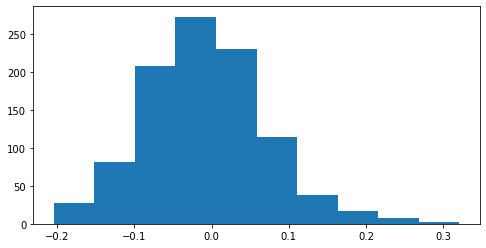

The standar error of the learned hedge is: 0.07885124
The mean error of the hedge is: -0.007773945


In [7]:
## Building test pathes to input architecture
xtest = []
for i in range(N+1):
    xtest = xtest + [testpaths[i,:]]

print("[Below]: Performance of learned hedge in the model (out of sample).")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(model_hedge.predict(xtest))
plt.show()
print("The standar error of the learned hedge is:", np.std(model_hedge.predict(xtest)))
print("The mean error of the hedge is:", np.mean(model_hedge.predict(xtest)))

#### ii) Rectified linear unit

Now, we compare the results of our network for the case of a rectified linear unit (relu) activation Function.

In [8]:
activator = "relu"
model_hedge = Deephedge(activator, a)
model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/15
200/200 [==============================] - 2s 3ms/step - loss: 46.2805
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 1.3630
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.4031
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 0.1950
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 0.1190
Epoch 6/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0837
Epoch 7/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0646
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0522
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0432
Epoch 10/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 11/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0318
Epoch 12/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0277
Epoch 13/15
200/200 [===

#### ii) Rectified linear unit: Model Evaluation

[Below]: Performance of learned hedge in the model (out of sample).


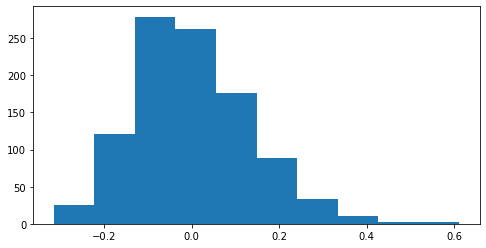

The standar error of the learned hedge is: 0.13221537
The mean error of the hedge is: 0.0012827213


In [9]:
print("[Below]: Performance of learned hedge in the model (out of sample).")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(model_hedge.predict(xtest))
plt.show()
print("The standar error of the learned hedge is:", np.std(model_hedge.predict(xtest)))
print("The mean error of the hedge is:", np.mean(model_hedge.predict(xtest)))

#### iii) Comparative of activation functions

From the previous analysis we can see that with the *relu* function we get a slightly worse approximation for the optimum strategy. Hence, in the following, we will be working with the tangens hyperbolicus activation function.


### Redo the training and testing for various values of $a$ and explain the effect of low/high transaction costs on the nature of the trading strategy and its performance.

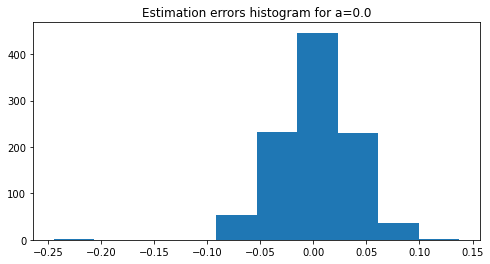

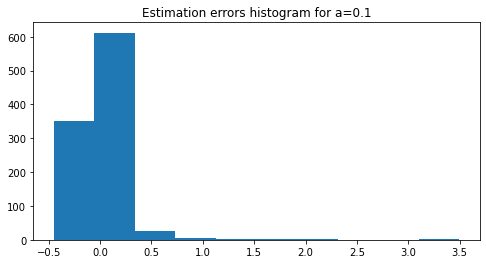

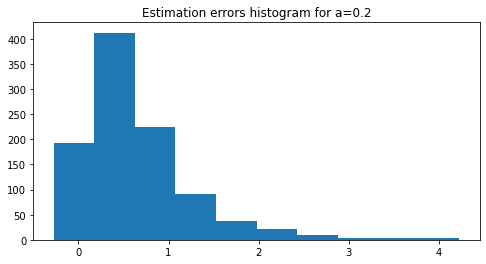

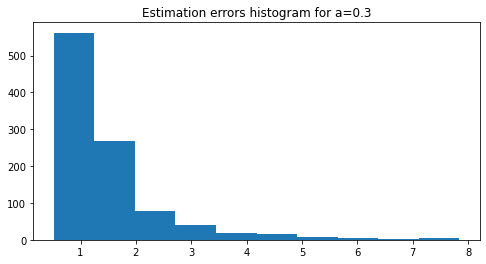

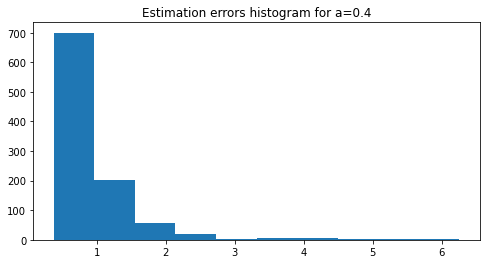

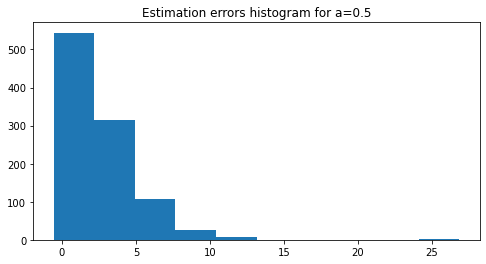

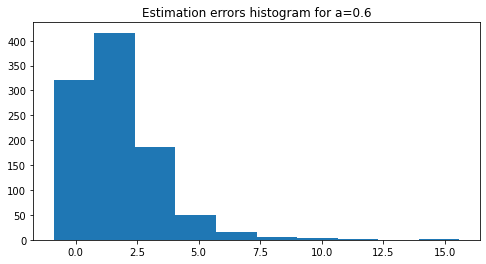

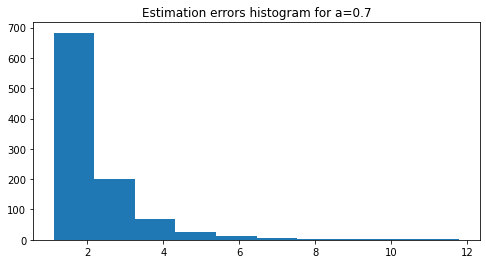

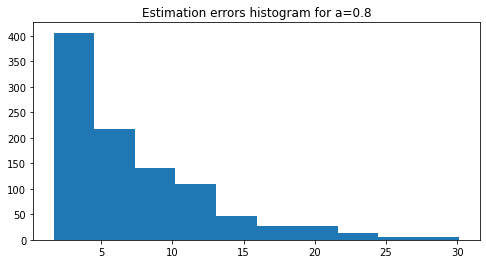

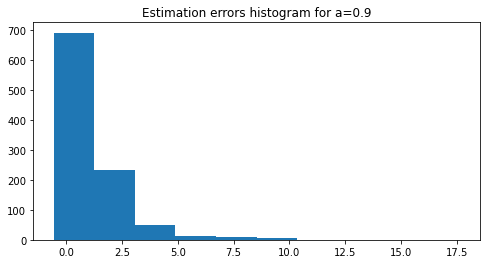

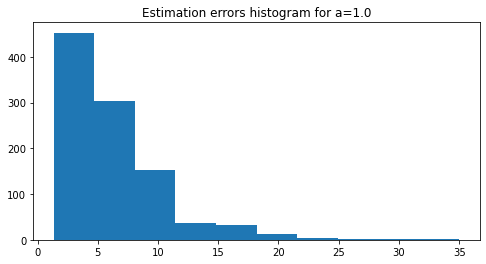

In [11]:
a = np.linspace(0, 1, 11)
activator = "tanh"
epochs = 15
ytrain = np.zeros((Ktrain, 1))
Mod_errs = pd.DataFrame({'a \ Statistic': ['mean', 'std dev', 'min', 'median', 'max']})

for j in range(len(a)):
    trainpaths = path(S0, 0, sigma, N, T, Ktrain) # Q-dynamics
    
    xtrain = []
    for i in range(N+1):
        xtrain = xtrain + [trainpaths[i,:]]

    model_hedge = Deephedge(activator, a[j])

    model_hedge.compile(optimizer='adam',loss='mean_squared_error')
    model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=False,batch_size=100)
    
    testpaths = path(S0, 0,sigma, N, T, Ktest) # P-dynamics
    
    ## Building test pathes to input architecture
    xtest = []
    for i in range(N+1):
        xtest = xtest + [testpaths[i,:]]

    errs = model_hedge.predict(xtest)
    plt.hist(errs)
    plt.title('Estimation errors histogram for a=' + str(a[j].round(2)))
    plt.show()
    
    Mod_errs = pd.concat([Mod_errs, pd.DataFrame({str(a[j].round(2)): [np.mean(errs), np.std(errs), 
                                            min(errs)[0], statistics.median(errs)[0], max(errs)[0]]})], axis=1)
    
#Mod_errs.transpose()

In [12]:
Mod_errs.transpose()

,0,1,2,3,4
a \ Statistic,mean,std dev,min,median,max
0.0,0.001866,0.034361,-0.244842,0.003942,0.13766
0.1,0.02125,0.237664,-0.453234,0.007537,3.499066
0.2,0.643888,0.616148,-0.276247,0.497242,4.230276
0.3,1.501772,0.993141,0.514308,1.161749,7.843757
0.4,0.978354,0.634239,0.376762,0.790755,6.257736
0.5,2.477334,2.393996,-0.565088,1.908864,26.854588
0.6,1.692456,1.686268,-0.891921,1.317836,15.600133
0.7,2.224451,1.106987,1.110044,1.869159,11.792924
0.8,7.36065,5.253125,1.675032,5.616412,30.149057


#### Effects of $a$ in trading strategies and performance

The previous table shows that we get the best-approximated strategy if we don't include costs in the model, i.e., if $a=0$. On the other side, if we include them, the approximation gets worse as the value of $a$ increases. The strategies are underestimating the payoff of the call option (payoff > wealth), which is why we get right-skewed errors; that is, they are concentrated on the right side of the distribution. This is logical since, in the Black-Scholes model, one of the assumptions is that the market is frictionless, which means that there are no transaction costs. Therefore, when we include them in the model, our approximation starts to fail, and it gets worse as we increase the friction in the market (the value of $a$).